In [216]:
import tarfile
import os
import sys
import logging
import re
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
from shapely.geometry import LineString

In [251]:
def extract(tar_path, target_path = 'tmp', mode = 'r:gz', logger = None):
    """
    input:
        tar_path string:
            path of tar file
        target_path string:
            path of target file
        mode string:
            mode of tar 
    """
    try:
        tar = tarfile.open(tar_path, mode)
        file_names = tar.getnames()
        # make sure that only two files contain
        #assert(len(file_names) == 2)
        # make sure the name of the files is right
        #TODO
        confs = []
        results = []
        if logger:
            logger.info('start extracting data from file: '+tar_path)
        file_names = [li for li in file_names if li.split('.')[-1] == 'txt']
        # logging start info
        for file_name in file_names:
            f = tar.extractfile(file_name)
            if 'configuration' in file_name:
                # use the configuration filename to get the result filename
                result_filename = file_name[:-18]+'.txt'
                # make sure the result file exist
                if result_filename not in file_names:
                    if logger:
                        logger.info('result file not found')
                    continue
                # extract the configuration file 
                f = tar.extractfile(file_name)
                conf = extract_configuration(file_name, f)
                # extract the result file
                f = tar.extractfile(result_filename)
                result = extract_result(file_name, f)
                # if mismatch 
                if len(conf) == len(result):
                    confs.append(conf)
                    results.append(result)
                elif len(conf) > len(result):
                    conf = conf[:len(result)]
                    confs.append(conf)
                    results.append(result)
                else:
                    if logger:
                        logger.error('Data mismatch in:'+ file_name)
                    else:
                        print('Data mismatch in:'+ file_name)
        tar.close()
        # combine conf and result
        conf = pd.concat(confs, axis = 0)
        result = pd.concat(results, axis = 0)
        target = pd.concat([conf, result], axis = 1)
        if logger:
            logger.info('end extracting')
        return target
    except:
        raise

def extract_configuration(filename, f):
    """
    input:
        filename string:
            the name of the file
        f file object:
            the file object
    """
    conf_columns = ['Jobid', 'Rot', 'List of Coordinates', 'Shapely Polygon']
    conf = pd.DataFrame(columns = conf_columns)
    for row_index, line in enumerate(f):
        l = line.decode("utf-8").strip()
        l = re.sub(r'\s+', ' ', l)
        ws = l.split(' ')
        assert(len(ws)>=2)
        conf.loc[row_index, 'Jobid'] = re.sub('[a-zA-Z/.]', '', filename)+str(row_index)
        conf.loc[row_index, 'Rot'] = ws[0]
        tmp_coor = fix_coordinate(ws[1:])
        conf.loc[row_index, 'List of Coordinates'] = tmp_coor
        conf.loc[row_index, 'Shapely Polygon'] = LineString(tmp_coor)
    return conf

def extract_result(filename, f):
    """
    input:
        filename string:
            the name of the file
        f file object:
            the file object    
    """
    result_columns = ['Metric1', 'Metric2', 'Metric3', 'Metric4']
    result = pd.DataFrame(columns = result_columns)
    for row_index, line in enumerate(f):
        l = line.decode("utf-8").strip()
        l = re.sub(r'\s+', ' ', l)
        ws = l.split(' ')
        if len(ws) != 6:
            print(ws)
        result.loc[row_index, 'Metric1'] = ws[2]
        result.loc[row_index, 'Metric2'] = ws[3]
        result.loc[row_index, 'Metric3'] = ws[4]
        result.loc[row_index, 'Metric4'] = ws[5]
    return result

def fix_coordinate(ws, logger = None):
    out = []
    out2 = []
    for w in ws:
        if w.count('.') == 1:
            out.append(float(w))
        elif w.count('.') > 1:
            # fix the problem
            tmp = []
            get_first(w, tmp)
            out.extend(tmp)
        else:
            # error??
            if logger:
                logger.error('coordinate error')
    if len(out)%2 != 0:
        logger.error('coordinate error')
    for i in range(0,len(out),2):
        out2.append((out[i],out[i+1]))
    return out2

In [214]:
def get_first(li, out):
    if li.count('.') > 1:
        add = li.index('.')+3
        out.append(float(li[:add]))
        get_first(li[add:], out)
    else:
        out.append(float(li))     

In [200]:
out = []
get_first('9.00115.80124.80124.80115.80', out)

In [252]:
#a = extract('../samples/82753-9348_results.tgz')
#a

In [188]:
a['Rot'].value_counts()

5.00     453
90.00    427
0.00     408
Name: Rot, dtype: int64

## main

In [219]:
# set logging
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler = logging.FileHandler('../log/extract_data.log')
handler.setLevel(logging.INFO)
formater = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formater)
logger = logging.getLogger(__name__)
logger.addHandler(handler)
#logger.info('This is a log info')

In [122]:
# read filename
filenames = os.listdir('../samples/')
filenames = [li for li in filenames if li.split('.')[-1] == 'tgz']
preffix = '../samples/'
filenames = [preffix+li for li in filenames]

In [250]:
# extract file
data = []
for filename in filenames:
    data.append(extract(filename, logger = logger))
data = pd.concat(data, axis = 0)

2019-01-08 17:21:15,943 - __main__ - INFO - start extracting data from file: ../samples/82754-8238_results.tgz
2019-01-08 17:21:19,174 - __main__ - INFO - end extracting
2019-01-08 17:21:19,195 - __main__ - INFO - start extracting data from file: ../samples/82753-9348_results.tgz
2019-01-08 17:21:22,411 - __main__ - INFO - end extracting


In [127]:
# save file
data.to_pickle('../sample.tmp')

In [141]:
len([float(i) for i in a["List of Coordinates"].iloc[0]])

26

In [154]:
list1

[(28.5, 60.1),
 (84.4, 88.3),
 (88.0, 80.5),
 (60.1, 28.5),
 (8.1, 0.5),
 (0.3, 4.1),
 (28.5, 0.0),
 (0.0, 7.9),
 (15.4, 16.2),
 (20.0, 13.4),
 (13.4, 20.0),
 (16.2, 15.5),
 (7.9, 0.0)]

In [145]:
list1 = []
temp = [float(i) for i in a["List of Coordinates"].iloc[0]]
for i in range(0,25,2):
    list1.append((temp[i],temp[i+1]))
    
line = LineString(list1)

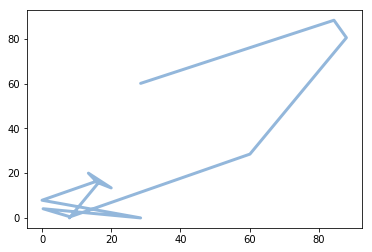

In [156]:
import matplotlib.pyplot as plt
x,y = line.xy
plt.figure()
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
plt.set_title('Polygon')

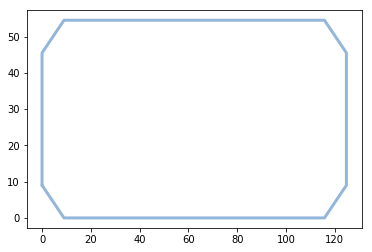

In [157]:
#[0 9; 9 0; 115.8 0; 124.8 9; 124.8 45.5; 115.8 54.5; 9 54.5; 0 45.5; 0 9]

x = [0,9,115.8,124.8,124.8,115.8,9,0,0]
y = [9, 0, 0, 9, 45.5, 54.5, 54.5, 45.5, 9]
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

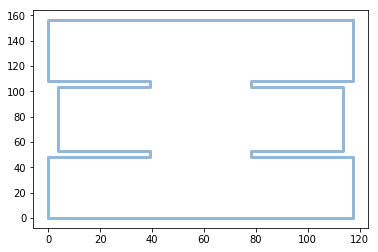

In [164]:
tmp = '117.4 156.1; 117.4 108; 78.2 108; 78.2 103; 113.6 103; 113.6 53; 78.2 53; 78.2 48; 117.4 48; 117.4 0; 0 0; 0 48; 39.2 48; 39.2 53; 3.8 53; 3.8 103; 39.2 103; 39.2 108; 0 108; 0 156.1; 117.4 156.1'
ls = tmp.split(';')
ls = [l.strip() for l in ls]
x = [float(l.split(' ')[0]) for l in ls]
y = [float(l.split(' ')[1]) for l in ls]
xy = [(ll, lr) for ll, lr in zip(x, y)]
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

In [168]:
figure = LineString(xy)
figure.bounds

(0.0, 0.0, 117.4, 156.1)